# Compilation of Quantum Circuits

In today's digital world, creating computer programs has become a crucial element of software development.
With the advent of high-level programming languages such as C++ or Python, the development process has become simpler and more efficient.
These languages enable developers to produce code that is more human-readable and understandable without having to worry about the underlying hardware's low-level features.
But before these programs can be executed on a computer, they must be translated into machine code that the computer can process.
This procedure is known as _compilation_, and it entails converting high-level code into a binary format that the computer's processor can directly execute.
By making it easier for more people to create computer programs, this has enabled the development of complex software applications that can run on many different platforms such as desktops, laptops, mobile phones or embedded devices.

Just as in classical computing, the design of quantum circuits and the development of quantum algorithms are fundamental in the development of quantum computing applications.
Quantum circuits are analogous to classical functions or programs in that they are a sequence of quantum gates that perform specific operations on quantum bits or qubits instead of classical bits.
Similarly to classical processors, quantum processors can only execute a certain set of native instructions, and they might further limit the qubits on which these operations might be applied.
Thus, any high-level quantum circuit (describing a quantum application) must be _compiled_ into a representation that can be executed on the targeted device.
Most importantly, the resulting quantum circuit must only use gates that are native to the device on which it shall be executed.
If the device only has limited connectivity between its qubits, it must only apply gates to qubits that are connected on the device.
Naturally, the efficiency of this compilation process is critical because it can have a significant impact on the performance of the resulting quantum program.
Inefficient compilation can lead to longer execution times, higher error rates, and reduced accuracy in the final result.
Therefore, developing efficient compilation methods for quantum programs is essential to overcome the challenges of quantum computing and realize the potential of this technology.

In the following, we mainly focus on the _quantum circuit mapping_ task.
This is a crucial step in the compilation flow, as it directly affects the feasibility and performance of the quantum circuit on a given device.
It involves finding a way to map the qubits of a quantum circuit to the qubits of a quantum device, while respecting the limited connectivity constraints of the device and minimizing the overhead of additional gates.
In most cases, it is not possible to statically define a mapping of the circuit's qubits to the device's qubits such that all gates of the circuit conform to the connectivity limitations of the device.
Consequently, this mapping has to change dynamically throughout the circuit.
This can be accomplished by using _SWAP_ gates that allow the position of two logical qubits on the architecture to be interchanged.
However, since any additional gate increases the error rate and, hence, reduces the accuracy of the computation, it is vital to keep the number of additionally added gates as low as possible.
It has been shown that even this small part in the compilation flow is an NP-complete problem.

The _MQT_ offers the quantum circuit mapping tool QMAP that allows one to generate circuits which satisfy all constraints given by the targeted architecture and, at the same time, keep the overhead in terms of additionally required quantum gates as low as possible.
More precisely, different approaches based on design automation techniques are provided, which are generic and can be easily configured for future architectures.
Among them is a heuristic, scalable solution for arbitrary circuits based on informed-search algorithms as well as a solution for obtaining mappings ensuring minimal overhead with respect to SWAP gate insertions.

_MQT_ offers many more methods for various compilation tasks, such as Clifford circuit synthesis, determining optimal sub-architectures, compiler optimization, and compilation techniques for different architectures or multi-level quantum systems.

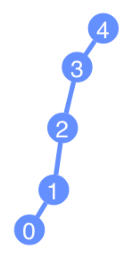

In [1]:
from qiskit.visualization import plot_gate_map
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.coupling import CouplingMap

coupling_map = CouplingMap.from_line(5)
backend = GenericBackendV2(num_qubits=5, coupling_map=coupling_map, basis_gates=["cx", "u"])

plot_gate_map(backend)

Then, mapping the circuit to that device merely requires the following lines of Python and results in the circuit shown below.

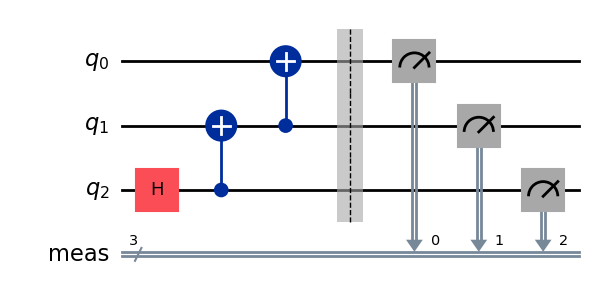

In [2]:
from mqt.qmap import compile
from mqt.bench import get_benchmark

circ = get_benchmark(benchmark_name="ghz", level="alg", circuit_size=3)
circ.draw(output="mpl")

In [3]:
circ_mapped, results = compile(circ, backend)

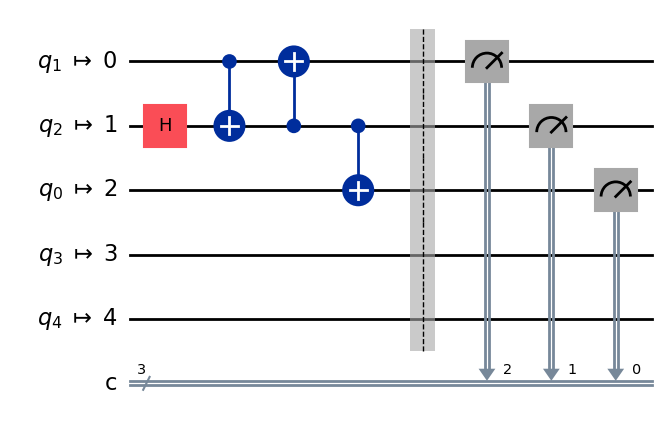

In [4]:
circ_mapped.draw(output='mpl')

## Let's run a 5 qubit GHZ from MQT Bench on the same device.

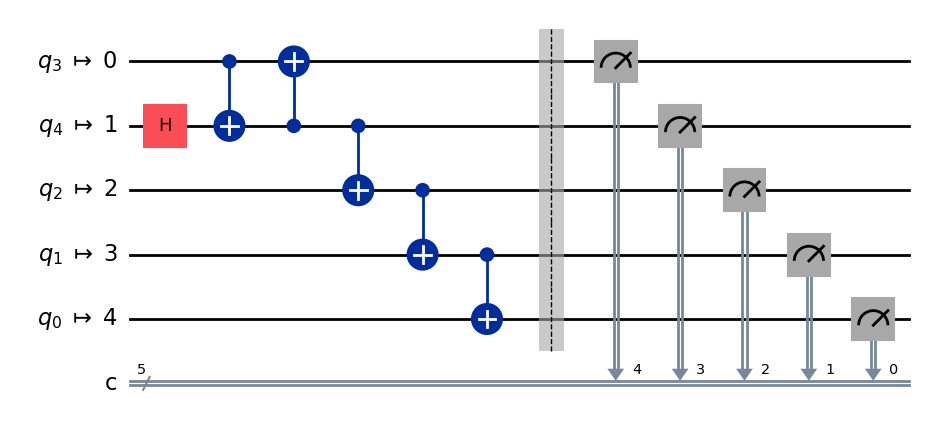

In [5]:
from mqt.bench import get_benchmark
circ=get_benchmark(benchmark_name="ghz", level="alg", circuit_size=5)
circ_mapped, results = compile(circ, backend)
circ_mapped.draw(output='mpl')

## Let's compile a larger Circuit

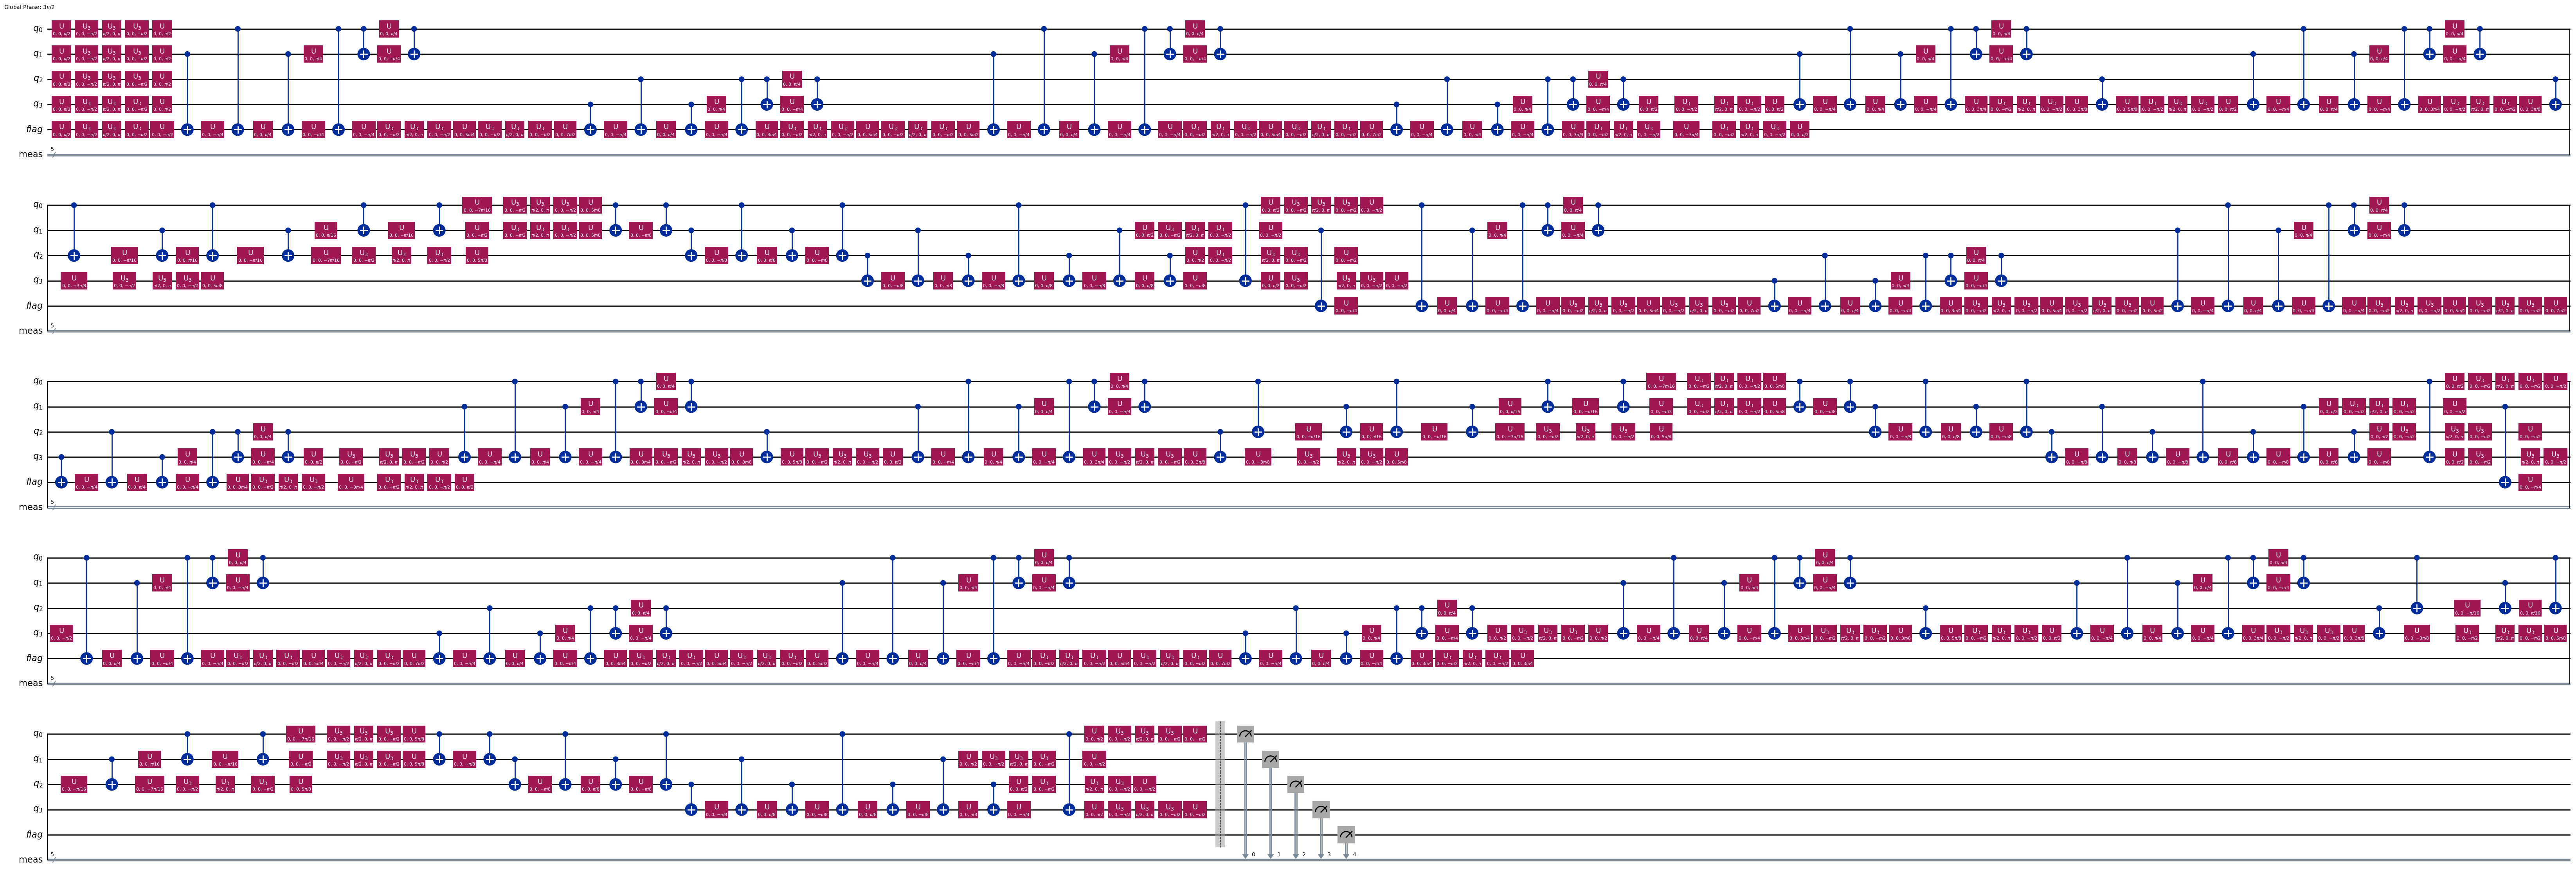

In [9]:
circ=get_benchmark(benchmark_name="grover-noancilla", level="nativegates", circuit_size=5).decompose(reps=3)
circ.draw(output="mpl", fold=100)

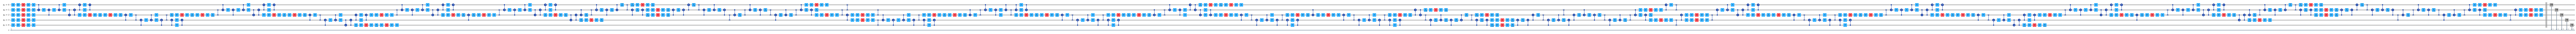

In [8]:
circ_mapped, results = compile(circ, backend)
circ_mapped.draw(output="mpl", fold=100)

In [9]:
circ_mapped.count_ops()

OrderedDict([('cx', 188),
             ('sdg', 144),
             ('p', 111),
             ('h', 64),
             ('tdg', 60),
             ('t', 54),
             ('swap', 50),
             ('s', 32),
             ('measure', 5),
             ('barrier', 1)])

## Use Qiskit's Compiler

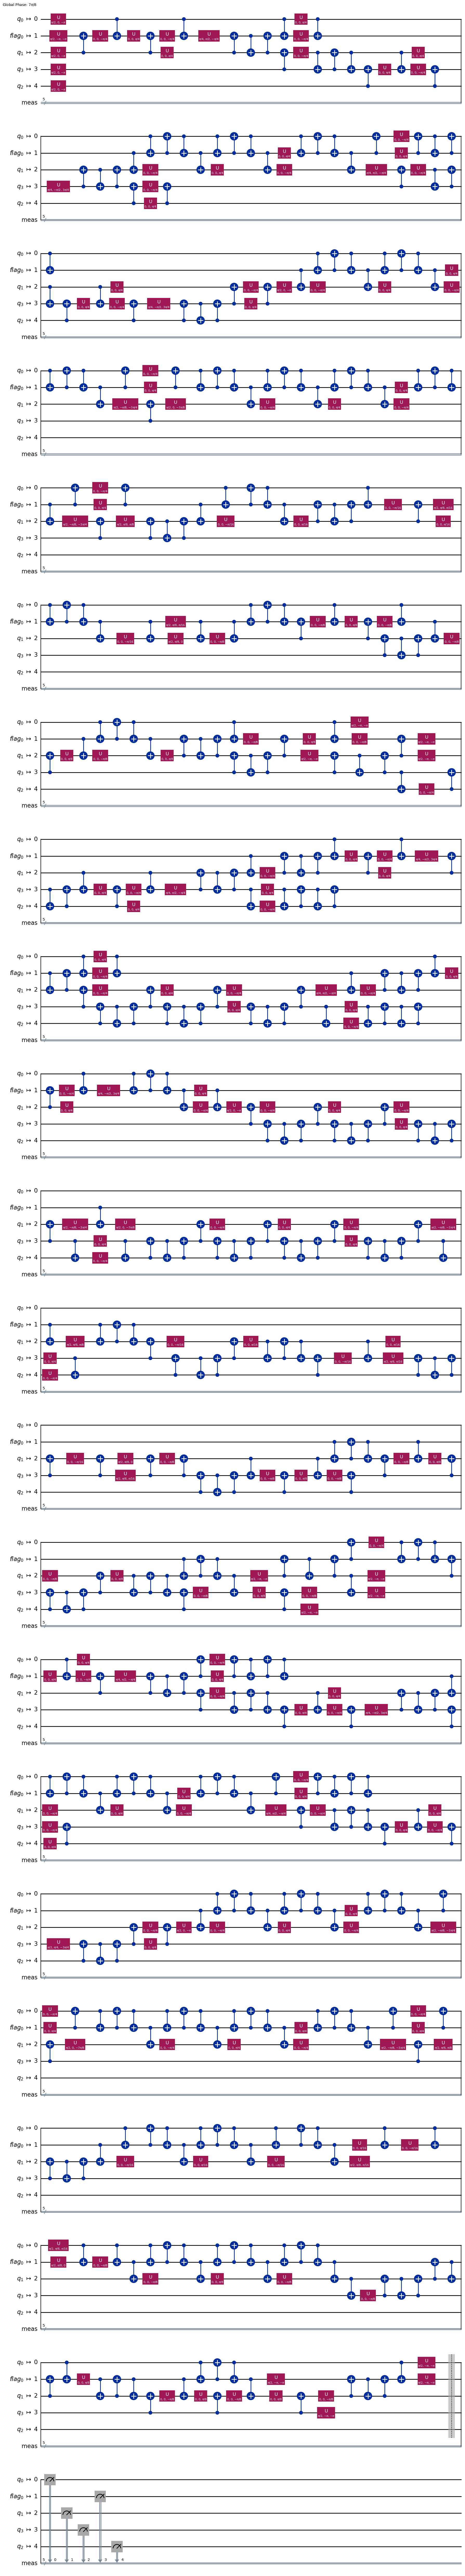

In [10]:
from qiskit import transpile
circ_mapped_qiskit = transpile(circ, backend=backend)
circ_mapped_qiskit.draw(output='mpl')

In [11]:
circ_mapped_qiskit.count_ops()

OrderedDict([('cx', 426), ('u', 209), ('measure', 5), ('barrier', 1)])

## Larger Quantum Device

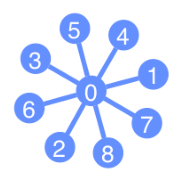

In [12]:
from qiskit.providers.fake_provider import GenericBackendV2

coupling_map = [[0, 1], [1,0], [0, 2], [2, 0], [0, 3], [3, 0], [0, 4], [4, 0], [0, 5], [5, 0], [0, 6], [6, 0], [0, 7], [7, 0], [0, 8], [8, 0]]
backend = GenericBackendV2(num_qubits=9, coupling_map=coupling_map)
plot_gate_map(backend)

In [ ]:
import time
swaps_heuristic = []
swaps_exact = []
swaps_qiskit = []

times_heuristic = []
times_exact = []
times_qiskit = []

qubit_range = range(2,9)
for i in qubit_range:
    print("Circuit size: ", i)
    circ = get_benchmark(benchmark_name="ae", level="alg", circuit_size=i).decompose(reps=2)

    start_time = time.time()
    circ_mapped, results = compile(circ, backend, method="heuristic")
    times_heuristic.append(time.time()-start_time)
    swaps_heuristic.append(circ_mapped.count_ops().get('swap', 0))
    print("MQT QMAP Heuristic SWAPs: ", circ_mapped.count_ops().get('swap', 0))

    start_time = time.time()
    circ_mapped, results = compile(circ, backend, method="exact")
    times_exact.append(time.time()-start_time)
    swaps_exact.append(circ_mapped.count_ops().get('swap', 0))
    print("MQT QMAP Exact SWAPs: ", circ_mapped.count_ops().get('swap', 0))

    start_time = time.time()
    circ_mapped = transpile(circ, coupling_map=coupling_map, optimization_level=3)
    times_qiskit.append(time.time()-start_time)
    swaps_qiskit.append(circ_mapped.count_ops().get('swap', 0))
    print("Qiskit SWAPs: ", circ_mapped.count_ops().get('swap', 0))

    print("----")


Circuit size:  2
MQT QMAP Heuristic SWAPs:  0
MQT QMAP Exact SWAPs:  0
Qiskit SWAPs:  0
----
Circuit size:  3
MQT QMAP Heuristic SWAPs:  1
MQT QMAP Exact SWAPs:  1
Qiskit SWAPs:  1
----
Circuit size:  4


In [ ]:
from matplotlib import pyplot as plt
plt.xlabel("Circuit size")
plt.ylabel("Number of SWAPs")
plt.title("Number of SWAPs for different methods")
plt.plot(qubit_range, swaps_heuristic, label="MQT QMAP Heuristic")
plt.plot(qubit_range, swaps_qiskit, label="Qiskit")
plt.plot(qubit_range, swaps_exact, label="MQT QMAP Exact")
plt.legend()

from matplotlib import pyplot as plt
plt.xlabel("Circuit size")
plt.ylabel("Time in s")
plt.title("Compilation time for different methods")
plt.plot(qubit_range, times_heuristic, label="MQT QMAP Heuristic")
plt.plot(qubit_range, times_qiskit, label="Qiskit")
plt.plot(qubit_range, times_exact, label="MQT QMAP Exact")
plt.legend()

In [ ]:
plt.xlabel("Compilation Time")
plt.ylabel("Time in s")
plt.title("Compilation times for different methods")
plt.plot(qubit_range, times_heuristic, label="MQT QMAP Heuristic")
plt.plot(qubit_range, times_qiskit, label="Qiskit")
plt.plot(qubit_range, times_exact, label="MQT QMAP Exact")
plt.legend()

## Inspiration for further tasks:

- Choose different algorithms from MQT Bench (see https://mqt.readthedocs.io/projects/bench/en/latest/Benchmark_selection.html)
- Adjust size and connectivity of considered backend (see https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.CouplingMap -> e.g., from_line, from_ring, from_full)